# Kinase conformations

This notebook explores the perfromance of the docking algorithms **Fred**, **Hybrid** and **Posit** across different kinase groups.

In [1]:
from pathlib import Path

from matplotlib import pyplot as plt
import pandas as pd
import seaborn as sns

In [2]:
sns.set() # Setting seaborn as default style even if use only matplotlib

In [3]:
OUT_DIR = Path("../pics")
OUT_DIR.mkdir(parents=True, exist_ok=True)

In [4]:
fred_results = pd.read_csv("../data/fred_results.csv", index_col=0)
hybrid_results = pd.read_csv("../data/hybrid_results.csv", index_col=0)
posit_results = pd.read_csv("../data/posit_results.csv", index_col=0)
docking_benchmark_dataset = pd.read_csv("../data/docking_benchmark_dataset.csv", index_col=0)
print(f"Total number of structures in benchmark: {len(docking_benchmark_dataset)}")
for kinase_group in docking_benchmark_dataset["kinase.group"].unique():
    n_structures = sum(docking_benchmark_dataset["kinase.group"] == kinase_group)
    print(f"Number of structures in benchmark from kinase group {kinase_group}: {n_structures}")

Total number of structures in benchmark: 589
Number of structures in benchmark from kinase group CAMK: 129
Number of structures in benchmark from kinase group TKL: 77
Number of structures in benchmark from kinase group TK: 139
Number of structures in benchmark from kinase group AGC: 54
Number of structures in benchmark from kinase group STE: 71
Number of structures in benchmark from kinase group Other: 119


## Performance across different kinase conformations

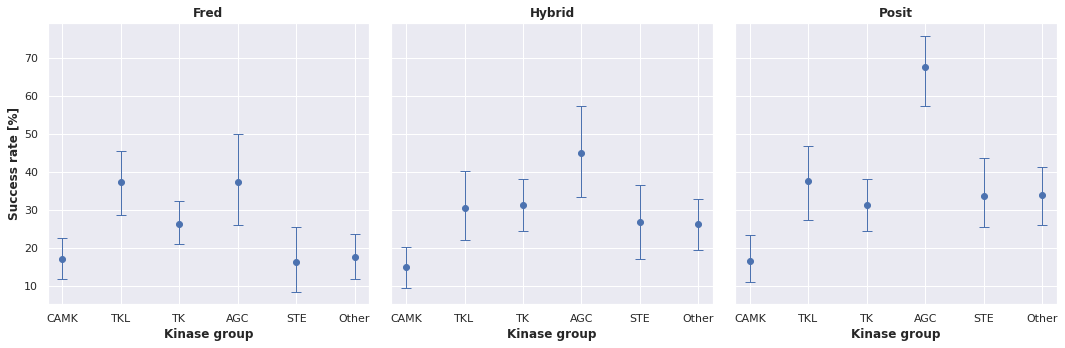

In [5]:
def plot_performance(docking_benchmark_dataset, fred_results, hybrid_results, posit_results, n_bootstrap=1000, ci=0.95, directory=OUT_DIR):
    
    # select pose 1 for Fred and Hybrid, i.e. best pose according to docking score
    fred_results = fred_results[fred_results["pose"] == 1]
    hybrid_results = hybrid_results[hybrid_results["pose"] == 1]
    
    # 3 subplots
    fig, axes = plt.subplots(1, 3, sharey=True, figsize=(15, 5))
    
    # sample success rates
    sampled_success_rates = []
    kinase_groups = docking_benchmark_dataset["kinase.group"].unique()
    for method, results in zip(["Fred", "Hybrid", "Posit"], [fred_results, hybrid_results, posit_results]):
        for kinase_group in kinase_groups:
            group_pdb_ids = docking_benchmark_dataset[
                docking_benchmark_dataset["kinase.group"] == kinase_group
            ]["structure.pdb_id"].to_list()
            result_selection = results[results["ligand_pdb_id"].isin(group_pdb_ids)]
            sampled_success_rates_i = []
            for _ in range(n_bootstrap):
                sampled_results = result_selection.groupby("ligand_pdb_id").sample(n=1)
                sampled_success_labels = (sampled_results["rmsd"] <= 2).to_list()
                sampled_success_rates_i.append(
                    (sum(sampled_success_labels) / len(sampled_success_labels)) * 100
                )
            sampled_success_rates_i = sorted(sampled_success_rates_i)
            mean = sum(sampled_success_rates_i) / len(sampled_success_rates_i)
            cutoff = (1 - ci) / 2
            lower_bound = sampled_success_rates_i[int(n_bootstrap * cutoff)]
            upper_bound = sampled_success_rates_i[int(n_bootstrap * (ci + cutoff))]
            sampled_success_rates.append([kinase_group, method, mean, lower_bound, upper_bound])
            
    # plot sampled data
    sampled_success_rates = pd.DataFrame(
        sampled_success_rates, 
        columns=["kinase_group", "method", "success_rate", "ci_lower", "ci_upper"]
    )
    for i, method in enumerate(["Fred", "Hybrid", "Posit"]):
        sampled_success_rates_i = sampled_success_rates[sampled_success_rates["method"] == method]
        axes[i].errorbar(
            x=sampled_success_rates_i["kinase_group"],
            y=sampled_success_rates_i["success_rate"],
            yerr=[
                sampled_success_rates_i["success_rate"] - sampled_success_rates_i["ci_lower"], 
                sampled_success_rates_i["ci_upper"] - sampled_success_rates_i["success_rate"]
            ],
            fmt="o",
            elinewidth=1,
            capsize=5,
            capthick=1
        )
        axes[i].set_xlabel("Kinase group", fontweight="bold")
        axes[i].set_title(method, fontweight="bold")
    axes[0].set_ylabel("Success rate [%]", fontweight="bold")
    
    plt.tight_layout()
    plt.savefig(directory / "performance_per_kinase_group.png", dpi=300)
    
    return sampled_success_rates
        
        
sampled_success_rates = plot_performance(docking_benchmark_dataset, fred_results, hybrid_results, posit_results)

In [6]:
sampled_success_rates

,kinase_group,method,success_rate,ci_lower,ci_upper
0,CAMK,Fred,17.058915,11.627907,22.480620
1,TKL,Fred,37.348052,28.571429,45.454545
2,TK,Fred,26.315827,20.863309,32.374101
3,AGC,Fred,37.390741,25.925926,50.000000
4,STE,Fred,16.269014,8.450704,25.352113
5,Other,Fred,17.655462,11.764706,23.529412
6,CAMK,Hybrid,14.842636,9.302326,20.155039
7,TKL,Hybrid,30.551948,22.077922,40.259740
8,TK,Hybrid,31.201439,24.460432,38.129496
9,AGC,Hybrid,44.940741,33.333333,57.407407
